HEAVILY inspired by https://github.com/georgetown-analytics/machine-learning/blob/master/notebook/Wheat%20Classification.ipynb

In [1]:
import sys
sys.path.insert(1, '..')
from table_reader import TableReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tr = TableReader()
df = tr.properties_vector(include_amenitites=True)
geodata = tr.geodata_vector()
tr.close()


In [3]:
df = pd.merge(df, geodata, on='listingID', how='left')

In [4]:
df['costlier_than_100'] = df['price'].apply(lambda price: 1 if price > 100 else 0)

In [5]:
features = df[df.columns.drop(['price', 'listingID', 'costlier_than_100'])]
label = df['costlier_than_100']

In [6]:
# Determine the frequency of each class
print(df.groupby('costlier_than_100')['costlier_than_100'].count())

costlier_than_100
0    5589
1    5662
Name: costlier_than_100, dtype: int64


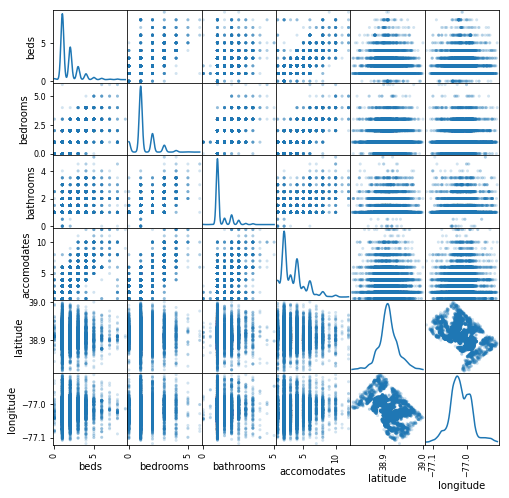

In [7]:
from pandas.plotting import scatter_matrix
scatter_features = features[['beds', 'bedrooms', 'bathrooms', 'accomodates', 'latitude', 'longitude',]]
scatter_matrix(scatter_features, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode our target variable
encoder = LabelEncoder().fit(label)
label = encoder.transform(label)

print(features.shape, label.shape)

(11251, 105) (11251,)


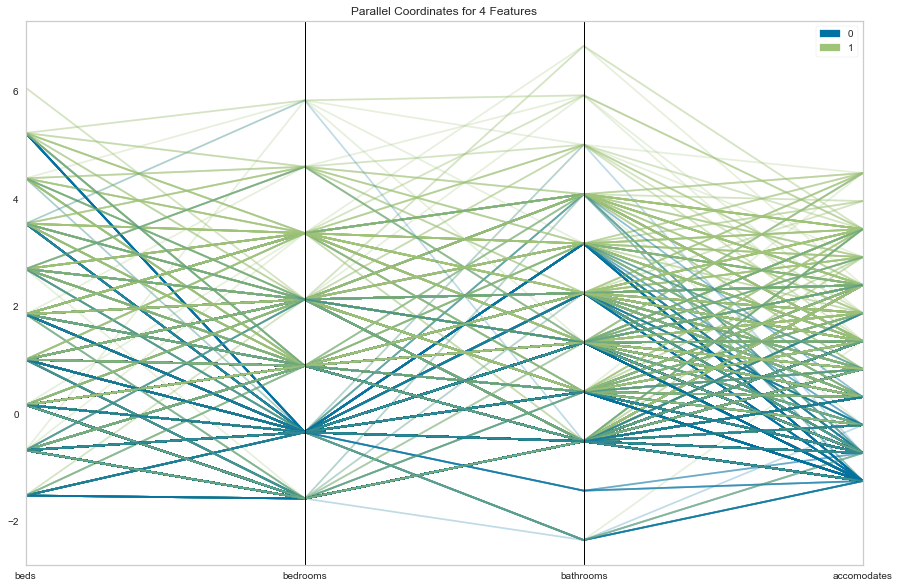

In [30]:
from yellowbrick.features import ParallelCoordinates
parallel_features = features[['beds', 'bedrooms', 'bathrooms', 'accomodates']]
visualizer = ParallelCoordinates(classes=encoder.classes_, normalize='standard', size=(1080, 720))
visualizer.fit_transform(parallel_features, label)
visualizer.poof(outpath="parallel_coords.png")

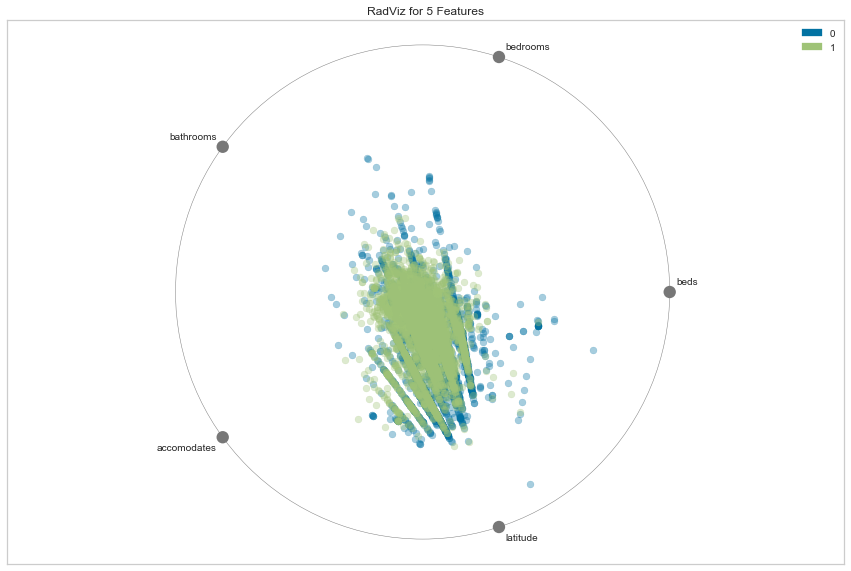

In [29]:
from yellowbrick.features import RadViz
rad_features = features[['beds', 'bedrooms', 'bathrooms', 'accomodates', 'latitude']]
visualizer = RadViz(classes=encoder.classes_, alpha=0.35, size=(1080, 720))
visualizer.fit_transform(rad_features, label)
visualizer.poof(outpath="radviz.png")

In [34]:
from sklearn import metrics

from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [39]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)

In [40]:
fit_and_evaluate(features, label, SVC, "AirBnb SVM Classifier", gamma = 'auto')

Validation scores are as follows:

precision    0.789716
recall       0.789531
accuracy     0.789531
f1           0.789489
dtype: float64


In [47]:
fit_and_evaluate(features, label, KNeighborsClassifier, "AirBnb kNN Classifier", n_neighbors=25)

Validation scores are as follows:

precision    0.784016
recall       0.783841
accuracy     0.783841
f1           0.783772
dtype: float64


In [43]:
fit_and_evaluate(features, label, RandomForestClassifier, "AirBnb Random Forest Classifier")

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

Validation scores are as follows:

precision    0.795157
recall       0.792639
accuracy     0.792639
f1           0.792293
dtype: float64


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
